# Covid-19 Portugal Notebook
## Applying logistic and exponential models to portuguese data

References:  
https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d
https://github.com/indiependente/covid19-models/blob/ce4bf3ae726b47c423007dba09649a519c0c8585/COVID19.ipynb


In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime as dt, timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getData():
    url = "https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv"
    df = pd.read_csv(url)
    return df

data = getData()

In [3]:
def prepareData(df):
    FMT = '%d/%m/%Y'
    
    df = df.loc[:, ['data', 'confirmados']]
    df = df[df['confirmados'] > 0]
    
    date_first_infection = dt.strptime(df.iloc[0]['data'], FMT)
    
    date = df['data']
    df['data'] = date.map(lambda x: (dt.strptime(
        x, FMT) - date_first_infection).days)

    return df,date_first_infection

df,date_first_infection = prepareData(data)

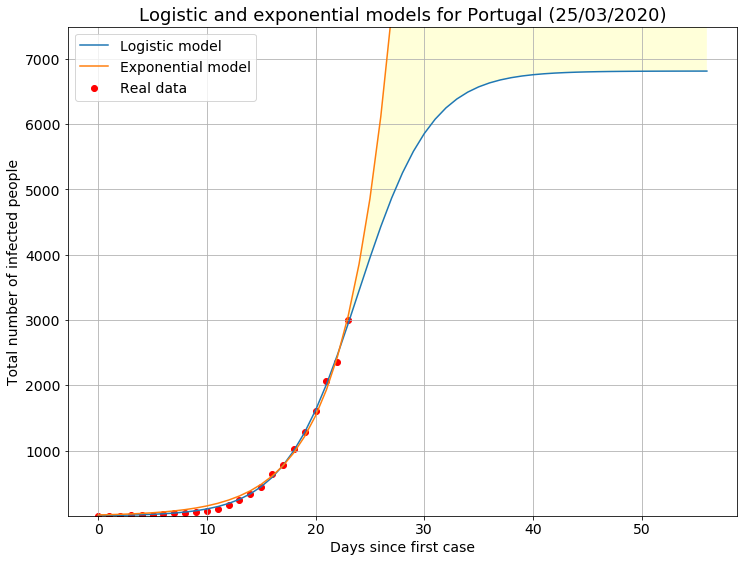

,data,best case,worst case
1,26-03-2020,3449,3857
2,27-03-2020,3951,4857
3,28-03-2020,4431,6116
4,29-03-2020,4869,7701
5,30-03-2020,5255,9697


Projections based on the logistic curve fit (best case scenario):
Infection speed     = 3.360 ± 0.121
Peak infections day = 25/03/2020 ± 16 hours
Total infected      = 6814 ± 752
End of infection   ~= 28/04/2020


In [4]:
def logistic_model(x, a, b, c):
    return c/(1+np.exp(-(x-b)/a))


def exponential_model(x, a, b, c):
    return a*np.exp(b*(x-c+10))


def fitModel(df, model, p0):
    x = list(df.iloc[:, 0])
    y = list(df.iloc[:, 1])
    fit = curve_fit(model, x, y, p0=p0, maxfev=1000)
    return fit


def infectionEnd(a, b, c, date_first_infection):
    sol = int(fsolve(lambda x: logistic_model(x, a, b, c) - int(c), b))
    return sol, date_first_infection + datetime.timedelta(days=sol)


def fitErrors(fit):
    return [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]


def printResults(fit, errors, end, date_first_infection):
    peakday = date_first_infection + \
        datetime.timedelta(days=fit[1])
    print("Projections based on the logistic curve fit (best case scenario):")
    print("Infection speed     = %.3f ± %.3f" % (fit[0],errors[0]))
    print("Peak infections day = %s ± %.0f hours" % (peakday.strftime("%d/%m/%Y"),errors[1]*24))
    print("Total infected      = %.0f ± %.0f" % (fit[2], errors[2]))
    print("End of infection   ~= %s" % (end.strftime("%d/%m/%Y")))


def plot(x, y, c, fit, exp_fit, sol, date_first_infection):
    pred_x = list(range(max(x), sol))
    last_day_data = date_first_infection+datetime.timedelta(days=x[-1])
    
    plt.rcParams['figure.figsize'] = [12, 9]
    plt.rc('font', size=14)
    plt.title('Logistic and exponential models for Portugal (%s)' % last_day_data.strftime("%d/%m/%Y") ,fontsize=18)
    
    # Real data
    plt.scatter(x, y, label="Real data", color="red")
    # Predicted logistic curve
    y_l=[logistic_model(i, fit[0][0], fit[0][1], fit[0][2]) for i in x+pred_x]
    plt.plot(x+pred_x, y_l, label="Logistic model")
    # Predicted exponential curve
    y_e = [exponential_model(i, exp_fit[0][0], exp_fit[0][1], exp_fit[0][2]) for i in x+pred_x]
    plt.plot(x+pred_x, y_e, label="Exponential model")
    
    y_l=[logistic_model(i, fit[0][0], fit[0][1], fit[0][2]) for i in pred_x]
    y_e = [exponential_model(i, exp_fit[0][0], exp_fit[0][1], exp_fit[0][2]) for i in pred_x]
    plt.fill_between(pred_x, y_l, y_e,facecolor='yellow', alpha=0.15)

    plt.legend()
    plt.xlabel("Days since first case")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9, c*1.1))
    plt.grid()
    plt.savefig('%s.png' % (last_day_data.strftime("%Y%m%d")))
    plt.show()
    
    
    data = [(date_first_infection + timedelta(days=x)).strftime("%d-%m-%Y") for x in pred_x]
    df = pd.DataFrame({'data' : data, 'best case' : y_l, 'worst case' : y_e})
    df['best case'] = df['best case'].astype(int)
    df['worst case'] = df['worst case'].astype(int)
    display(df.iloc[1:].head())
    df.to_csv('%s.csv' % (last_day_data.strftime("%Y%m%d")), index = False)
    


fit = fitModel(df, logistic_model, [2, 20, 200])
exp_fit = fitModel(df, exponential_model, [1, 1, 1])
errors = fitErrors(fit)
sol, end = infectionEnd(fit[0][0], fit[0][1], fit[0][2], date_first_infection)

plot(list(df.iloc[:, 0]), list(df.iloc[:, 1]),
     fit[0][2], fit, exp_fit, sol, date_first_infection)

printResults(fit[0], errors, end, date_first_infection)


In [5]:
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])
y_pred_logistic = [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x]
y_pred_exp =  [exponential_model(i,exp_fit[0][0], exp_fit[0][1], exp_fit[0][2]) for i in x]
print("Logistic curve mean squared error: %.0f" % (mean_squared_error(y,y_pred_logistic)))
print("Exponential curve mean squared error: %.0f" % (mean_squared_error(y,y_pred_exp)))

Logistic curve mean squared error: 886
Exponential curve mean squared error: 3154
